# $l_1$--regularization
$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\renewcommand{\a}{\alpha}             $ 
$\renewcommand{\b}{\beta}              $ 
$\renewcommand{\c}{\gamma}             $ 
$\renewcommand{\d}{\delta}             $ 
$\newcommand{\D}{\Delta}               $ 
$\newcommand{\la}{\lambda}             $ 
$\renewcommand{\t}{\tau}               $ 
$\newcommand{\s}{\sigma}               $ 
$\newcommand{\e}{\varepsilon}          $ 
$\renewcommand{\th}{\theta}            $ 
$\newcommand{\x}{\bar x}               $ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\E}{\mathcal E}           $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\newcommand{\nf}[1]{\nabla f(#1)}     $
$\newcommand{\hx}{\hat x}               $
$\newcommand{\hy}{\hat y}               $
$\DeclareMathOperator{\prox}{prox}      $
$\DeclareMathOperator{\argmin}{argmin}  $
$\DeclareMathOperator{\dom}{dom}        $
$\DeclareMathOperator{\id}{Id}          $
$\DeclareMathOperator{\conv}{conv}      $

We want to minimize:
$$
\min_x \frac 1 2 ||Ax-b||^2 + \lambda  ||x||_1 =: f(Ax)+g(x),
$$
where $A\in \R^{m\times n}$ is a matrix data, $b\in \R^m$ is a given observation, and $x\in \R^n$ is an unknown signal.

We can rewrite the problem above in a primal-dual form as follows:
$$
\min_x \max_y g(x)+(Ax,y)-f^*(y),
$$
where $f(x) = \frac 1 2 ||x-b||^2$, $f^*(y) = \frac 1 2 ||y||^2 + (b,y) = \frac 1 2 ||y+b||^2 -\frac{1}{2}||b||^2$ and $g(x) = \lambda ||x||_1$.

For the problem in a primal-dual form we apply primal-dual methods and for the problem in a primal form we apply proximal gradient method and FISTA. For this we set $h(x) = f(Ax)$ and get $\nabla h(x) = A^*(Ax-b)$.

In [1]:
import matplotlib.pyplot as plt

from opt_operators import *
from methods.algorithms import *
from methods.pd_algorithms import *
from methods.gr_pd_algorithms import *


import scipy.sparse.linalg as spr_LA
#from skimage import data, transform, img_as_float, transform
#from skimage.color import rgb2gray
from tomo_utils import generate_synthetic_data, build_projection_operator


We construct our data in one of the following ways below. We will use a fixed random generator for all our data to make experiments reproducible.

In [2]:
gen = 100

In [3]:
n = 2000
m = 1000
#n = 10
#m = 2
s = 100
la = 0.1

np.random.seed(gen)
A = np.random.normal(0,1, (m,n))
np.random.seed(gen)
w = np.random.uniform(-10,10, n)
w[s:] = 0
np.random.seed(gen)
w = np.random.permutation(w)

In [11]:
n = 2000
m = 1000
s = 100
la = 0.1

np.random.seed(gen)
A = np.random.normal(0,1, (m,n))

np.random.seed(gen)
w = np.random.uniform(-10,10, n)

#w = np.random.normal(0,1, n)
w[s:] = 0
np.random.seed(gen)
w = np.random.permutation(w)

For the problem below we took $p = 0.5$ or $p = 0.9$

In [24]:
n = 2000
m = 1000
s = 100
la = 0.1

np.random.seed(gen)
B = np.random.normal(0,1, (m,n))
p = 0.9
A = np.zeros((m,n))
A[:,0] = B[:,0]/np.sqrt(1-p**2)
for j in np.arange(1,n):
    A[:,j] = p*A[:,j-1] + B[:,j]

np.random.seed(gen)
w = np.random.uniform(-10,10, n)
w[s:] = 0
np.random.seed(gen)
w = np.random.permutation(w)

Define $\nu$ and $b$

In [4]:
np.random.seed(gen)
nu = np.random.normal(0,0.1, m)
b = A.dot(w) + nu

Define all ingredients for primal-dual methods and proximal gradient-like

In [5]:
def f_conj(y):
    return 0.5*(y+b).dot(y+b)

def g(x):
    return la*LA.norm(x,1)

def prox_g(x, rho):
    return prox_norm_1(x,la*rho)

def prox_f_conj(y, rho):
    return (y - rho*b)/(1+rho)

def prox_f(y, rho):
    return (y + rho*b)/(1+rho)

# define energy 
def J(x,y):
    t = A.dot(x)-b
    return 0.5* t.dot(t) + la* LA.norm(x,1)
# We need the following in order to apply accelerated primal-dual with strongly convex primal term.
def J1(y,x):
    return J(x,y)


#### for proximal gradient method and FISTA
def dh(x):
    return A.T.dot(A.dot(x)-b)

def F(x):
    return J(x,1)

Compute matrix norm of operator $A$. This may be long if you consider large-scale problems.

In [6]:
L = np.sqrt(np.max(LA.eigh(A.dot(A.T))[0]))

# starting points
x0 = np.zeros(n)
y0 = -b

# step size for PDA and GRPDA
tau = 1./L
sigma = 1./L
phi = 1.618


sqrt_phi = np.sqrt(phi)
tau1 = tau*sqrt_phi      # for Golden ratio PDA
sigma1 = sigma*sqrt_phi    # for Golden ratio PDA

# step size for GRAAL
la_gr = 1.618/2 * 1./L


In [7]:
# number of iterations
N = 7000

phi = 1.3; s_p = np.sqrt(phi*(2*phi+2-phi**2)/(1+phi));print(s_p)
ans1 = pd_Golden(J, prox_g, prox_f_conj, A, x0, y0, 0.5*sigma*s_p, 2*tau*s_p,phi, numb_iter=N)
phi = 1.6;s_p = np.sqrt(phi*(2*phi+2-phi**2)/(1+phi));print(s_p)
ans2 = pd_Golden(J, prox_g, prox_f_conj, A, x0, y0, 0.5*sigma*s_p, 2*tau*s_p,phi, numb_iter=N)
phi = 2; s_p = np.sqrt(phi*(2*phi+2-phi**2)/(1+phi));print(s_p)
ans3 = pd_Golden(J, prox_g, prox_f_conj, A, x0, y0, 0.5*sigma*s_p, 2*tau*s_p,phi, numb_iter=N)
phi = 2.3; s_p = np.sqrt(phi*(2*phi+2-phi**2)/(1+phi));print(s_p)
ans4 = pd_Golden(J, prox_g, prox_f_conj, A, x0, y0, 0.5*sigma*s_p, 2*tau*s_p,phi, numb_iter=N)


phi = 2; s_p = np.sqrt(2+0.5*sigma);print(s_p)
ans5 = pd_Golden_y(J, prox_g, prox_f_conj, A, x0, y0, 0.5*sigma*s_p, 2*tau*s_p,phi, numb_iter=N)

1.2824907830840937
----- Golden-Ratio PDA-----
Time execution: 18.3
1.2746040109051062
----- Golden-Ratio PDA-----
Time execution: 17.41
1.1547005383792515
----- Golden-Ratio PDA-----
Time execution: 16.88
0.9555261917029294
----- Golden-Ratio PDA-----
Time execution: 16.98
1.4165360078891802
----- Golden-Ratio PDA-----
Time execution: 16.92


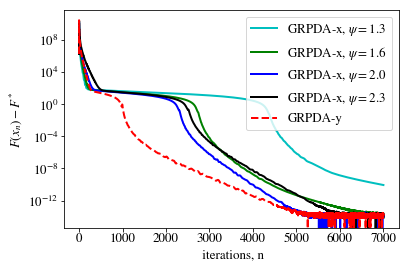

In [8]:
import matplotlib as mpl
mpl.rc('lines', linewidth=2)
mpl.rcParams.update(
    {'font.size': 13, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
mpl.rcParams['xtick.major.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 2

t = min(ans1[0]+ans2[0]+ans3[0]+ans4[0])
plt.plot(ans1[0]-t, 'c',label = 'GRPDA-x, $\psi=1.3$')
plt.plot(ans2[0]-t, 'g', label = 'GRPDA-x, $\psi=1.6$')
plt.plot(ans3[0]-t, 'b',label = 'GRPDA-x, $\psi=2.0$')
plt.plot(ans4[0]-t, 'k',label = 'GRPDA-x, $\psi=2.3$')

plt.plot(ans5[0]-t, 'r--',label = 'GRPDA-y')

plt.yscale('log')
plt.xlabel(u' iterations, n')
plt.ylabel('$F(x_n)-F^*$')
#plt.axis([-1000,20000, 1e-16,1e+4])
plt.legend()
#plt.savefig('figures/LR-psi-3.pdf')
plt.show()